In [1]:
import numpy as np
from scipy.stats import percentileofscore
import itolapi
from itolapi import Itol
import os
from pathlib import Path
import sys

import pandas as pd
import toytree       # a tree plotting library
import toyplot       # a general plotting library
import numpy as np   # numerical library
import os
from Bio import SeqIO
from Bio import Entrez
import subprocess
import toyplot.png
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import subprocess
import multiprocessing as mp
import ast
from Bio.Data import CodonTable

from Bio.Seq import Seq
from Bio.SeqUtils import seq3
import random
from Bio.SeqUtils import GC123
import pickle
sys.path.insert(0, '/net/bos-nfsisilon/ifs/rc_labs/extavour_lab/rkapoor/home_migrate')
import tax_pkg
from tax_pkg import taxid
import itertools

/n/home11/rkapoor/.conda/envs/rishabh/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
hgt_pipeline_final_2/data_upload_3_24_2025/parent_neofunctionalization_dnds

In [3]:
!tar -czf parent_neofunctionalization_dnds_data.tar.gz -C data_upload_3_24_2025 parent_neofunctionalization_dnds

In [11]:
#select all hgt and metazoan intervals from genus-specific chimeras for analysis 
dfc=pd.read_csv("revised_cluster_info_v3.csv",index_col=0)
genus=dfc[dfc.tax_span_rank.isin(["species","genus","subgenus","subspecies"])]
inters=[]
for index, row in genus.iterrows():
    inters.extend(ast.literal_eval(row.HGT_intervals))
    inters.extend(ast.literal_eval(row.Meta_intervals))
    ##load dictionary of within-genome parents at e=1e-10
with open("meta_only.pickle", 'rb') as file:
    meta_only = pickle.load(file)
with open("hgt_only.pickle", 'rb') as file:
    hgt_only = pickle.load(file)
dfc=dfc.set_index("representative_seq")

## Branch-specific dn/ds analysis for chimeras found in multiple species within the same genus

In [3]:
genus_limited=dfc[dfc.tax_span_rank.str.contains("genus")].representative_seq

In [8]:
#populate a dictionary with the names and coordinates of homologous regions in non-chimeric hits
#limit to hits within the same taxonomic family as each chimera
non_chimeric_parvs={}
hgt_one_inters=[x for x in hgt_only if x.split(';')[1] in set(genus_limited) and len(hgt_only[x])>0]
for inter in hgt_one_inters:
    # print(inter)
    blast_inter_df=pd.read_csv(f"blast_round_two_data/{inter}.tsv",sep="\t")
    try:
        tid=int(blast_inter_df[blast_inter_df["sseqid"]==inter.split(";")[1]].iloc[0,3])
    except:
        species_name=dfc.loc[inter.split(";")[1],"organism"].split("(")[0].strip()
        tid=int(blast_inter_df[blast_inter_df["sscinames"]==species_name].iloc[0,4])
    blast_inter_df=blast_inter_df[blast_inter_df['staxids'].astype(str)!=str(tid)]
    l=taxid.get_lineage(tid,{})
    self_family=l["family"]
    blast_inter_df=blast_inter_df[blast_inter_df['evalue']<1e-5]
    blast_inter_df=blast_inter_df[blast_inter_df['sphylums']=="Arthropoda"]
    
    hgt_ids=set(blast_inter_df["sseqid"])
    for meta_inter in [x for x in os.listdir(f"blast_round_two_data") if inter.split(";")[1] in x and "Meta" in x]:
        meta_df=pd.read_csv(f"blast_round_two_data/{meta_inter}",sep="\t",header=None)
        ##filter out potential secondary chimeras (hits to metazoan region) in other species
        hgt_ids=hgt_ids-set(meta_df[1])
        
    blast_inter_df=blast_inter_df[blast_inter_df["sseqid"].isin(hgt_ids)]
    taxids=[x.split(";") for x in blast_inter_df['staxids'].astype(str)]
    taxids=set([int(x) for x in (itertools.chain.from_iterable(taxids))])
    same_family=[]
    for x in taxids:
        l=taxid.get_lineage(x,{})
        if "family" in l.keys() and str(l["family"])==self_family:
            same_family.append(x)
    if len(same_family)>0:
        print(inter)
        same_family_index=[]
        for ti in same_family:
            for index, row in blast_inter_df.iterrows():
                if str(ti) in str(row['staxids']):
                    same_family_index.append(index)
        blast_inter_df=blast_inter_df.loc[same_family_index,:]
        blast_inter_df=blast_inter_df.loc[blast_inter_df.groupby('staxids')['evalue'].idxmin()]
        
        interv_par={}
        for index, row in blast_inter_df.iterrows():
            name=row['sseqid']
            start=row['sstart']
            end=row['send']
            interv_par[name]=(start,end,row[4])
        non_chimeric_parvs[inter]=interv_par
 

GCF_000002335.3;XP_015833841.1;HGT_(97,339)
GCF_015228065.1;XP_037790819.1;HGT_(738,1165)
GCF_021134715.1;XP_046456339.1;HGT_(49,253)
GCF_019393585.1;XP_051173821.1;HGT_(17,106)
GCF_021234035.1;XP_046649021.1;HGT_(451,633)


In [9]:
##repeat above process but to find hgt intervals in other species
meta_one_inters=[x for x in meta_only if x.split(';')[1] in set(genus_limited) and len(meta_only[x])>0]
for inter in meta_one_inters:
    blast_inter_df=pd.read_csv(f"blast_round_two_data/{inter}.tsv",sep="\t")
    try:
        tid=int(blast_inter_df[blast_inter_df["sseqid"]==inter.split(";")[1]].iloc[0,3])
    except:
        species_name=dfc.loc[inter.split(";")[1],"organism"].split("(")[0].strip()
        tid=int(blast_inter_df[blast_inter_df["sscinames"]==species_name].iloc[0,4])
    blast_inter_df=blast_inter_df[blast_inter_df['staxids'].astype(str)!=str(tid)]
    l=taxid.get_lineage(tid,{})
    self_family=l["family"]
    blast_inter_df=blast_inter_df[blast_inter_df['evalue']<1e-5]
    blast_inter_df=blast_inter_df[blast_inter_df['sphylums']=="Arthropoda"]
    meta_ids=set(blast_inter_df["sseqid"])
    for hgt_inter in [x for x in os.listdir(f"blast_round_two_data") if inter.split(";")[1] in x and "HGT" in x]:
        hgt_df=pd.read_csv(f"blast_round_two_data/{hgt_inter}",sep="\t",header=None)
        meta_ids=meta_ids-set(hgt_df[1])
        
    blast_inter_df=blast_inter_df[blast_inter_df["sseqid"].isin(meta_ids)]
    taxids=[x.split(";") for x in blast_inter_df['staxids'].astype(str)]
    taxids=set([int(x) for x in (itertools.chain.from_iterable(taxids))])
    same_family=[]
    for x in taxids:
        l=taxid.get_lineage(x,{})
        if "family" in l.keys() and str(l["family"])==self_family:
            same_family.append(x)
    if len(same_family)>0:
        print(inter)
        same_family_index=[]
        for ti in same_family:
            for index, row in blast_inter_df.iterrows():
                if str(ti) in str(row['staxids']):
                    same_family_index.append(index)
        blast_inter_df=blast_inter_df.loc[same_family_index,:]
        blast_inter_df=blast_inter_df.loc[blast_inter_df.groupby('staxids')['evalue'].idxmin()]
        blast_inter_df=blast_inter_df.loc[blast_inter_df.groupby('staxids')['evalue'].idxmin()]
        interv_par={}
        for index, row in blast_inter_df.iterrows():
            name=row['sseqid']
            start=row['sstart']
            end=row['send']
            interv_par[name]=(start,end,row[4])
        non_chimeric_parvs[inter]=interv_par
  

/tmp/ipykernel_3712973/2703076200.py:16: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  hgt_df=pd.read_csv(f"blast_round_two_data/{hgt_inter}",sep="\t",header=None)


GCF_015228065.1;XP_037790819.1;Meta_(45,640)
GCF_016920785.2;XP_029821973.3;Meta_(1,287)
GCF_000002335.3;XP_015833841.1;Meta_(1114,1237)
GCF_021234035.1;XP_046649021.1;Meta_(72,351)
GCF_021134715.1;XP_046439036.1;Meta_(421,823)
GCF_021134715.1;XP_046456339.1;Meta_(1765,1928)


In [16]:
chimeric_homologs={}
for x in inters:
    l=[]
    if x in chimeric_parvs:
        l=list(chimeric_parvs[x].keys())
    l.append(x.split(";")[1])
    chimeric_homologs[x]=l

In [ ]:
import pickle


In [19]:

# Define the filename for the pickle file
pickle_file = "dnds_branch_chimeras.pickle"

# Save the dictionary as a pickle file
with open(pickle_file, "wb") as f:
    pickle.dump(chimeric_homologs, f)


In [11]:
#populate a dictionary with the names and coordinates of homologous regions in chimeric genes (hits for all metazoan and hgt genes)
#limit to hits within the same family as each chimera
chimeric_parvs={}

for inter in non_chimeric_parvs:
    blast_inter_df=pd.read_csv(f"blast_round_two_data/{inter}.tsv",sep="\t")
    try:
        tid=int(blast_inter_df[blast_inter_df["sseqid"]==inter.split(";")[1]].iloc[0,3])
    except:
        species_name=dfc.loc[inter.split(";")[1],"organism"].split("(")[0].strip()
        tid=int(blast_inter_df[blast_inter_df["sscinames"]==species_name].iloc[0,4])
    blast_inter_df=blast_inter_df[blast_inter_df['staxids'].astype(str)!=str(tid)]
    l=taxid.get_lineage(tid,{})
    self_family=l["family"]
    blast_inter_df=blast_inter_df[blast_inter_df['evalue']<1e-5]
    blast_inter_df=blast_inter_df[blast_inter_df['sphylums']=="Arthropoda"]

    both_ids=set(blast_inter_df["sseqid"])
    
    if "HGT" in inter:
        for meta_inter in [x for x in os.listdir(f"blast_round_two_data") if inter.split(";")[1] in x and "Meta" in x]:
            meta_df=pd.read_csv(f"blast_round_two_data/{meta_inter}",sep="\t")
            both_ids=both_ids&set(meta_df['sseqid'])
    else:
        for hgt_inter in [x for x in os.listdir(f"blast_round_two_data") if inter.split(";")[1] in x and "HGT" in x]:
            hgt_df=pd.read_csv(f"blast_round_two_data/{hgt_inter}",sep="\t")
            both_ids=both_ids&set(hgt_df['sseqid'])
        
        
    blast_inter_df=blast_inter_df[blast_inter_df["sseqid"].isin(both_ids)]
    taxids=[x.split(";") for x in blast_inter_df['staxids'].astype(str)]
    taxids=set([int(x) for x in (itertools.chain.from_iterable(taxids))])
    same_family=[]
    for x in taxids:
        l=taxid.get_lineage(x,{})
        if "family" in l.keys() and str(l["family"])==self_family:
            same_family.append(x)
    if len(same_family)>0:
        print(inter)
        same_family_index=[]
        for ti in same_family:
            for index, row in blast_inter_df.iterrows():
                if str(ti) in str(row['staxids']):
                    same_family_index.append(index)
        blast_inter_df=blast_inter_df.loc[same_family_index,:]
        blast_inter_df=blast_inter_df.loc[blast_inter_df.groupby('staxids')['evalue'].idxmin()]
        
        interv_par={}
        for index, row in blast_inter_df.iterrows():
            name=row['sseqid']
            start=row['sstart']
            end=row['send']
            interv_par[name]=(start,end,row[4])
        chimeric_parvs[inter]=interv_par

GCF_000002335.3;XP_015833841.1;HGT_(97,339)
GCF_015228065.1;XP_037790819.1;HGT_(738,1165)
GCF_021134715.1;XP_046456339.1;HGT_(49,253)
GCF_019393585.1;XP_051173821.1;HGT_(17,106)
GCF_021234035.1;XP_046649021.1;HGT_(451,633)
GCF_015228065.1;XP_037790819.1;Meta_(45,640)
GCF_016920785.2;XP_029821973.3;Meta_(1,287)
GCF_000002335.3;XP_015833841.1;Meta_(1114,1237)
GCF_021234035.1;XP_046649021.1;Meta_(72,351)
GCF_021134715.1;XP_046439036.1;Meta_(421,823)
GCF_021134715.1;XP_046456339.1;Meta_(1765,1928)


In [ ]:
#write protein and nucleotide fastas for all homologous intervals for each interval
#generate alignments and run iqtree for ML tree inference
for inter in non_chimeric_parvs:
    interv_par=chimeric_parvs[inter]|non_chimeric_parvs[inter]
    try:
        subprocess.run(["rm","-r", f"multi_dnds_parent/{inter}"])
    except:
        p=1
    try:
        subprocess.run(["mkdir", f"multi_dnds_parent/{inter}"])
    except:
        p=1
    fprot=open(f"multi_dnds_parent/{inter}/concatenated_prot1.fasta","w")
    fnuc=open(f"multi_dnds_parent/{inter}/concatenated_nuc1.fasta","w")
    for c in interv_par:

        try:
            subprocess.run(["mkdir", f"multi_dnds_parent/{inter}/{c}"])
        except:
            p=1
        url_na=f"http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=protein&id={c}&rettype=fasta_cds_na" 
        url_prot=f"http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=protein&id={c}&rettype=fasta" 
        subprocess.run(["wget",url_na,"-O",f"multi_dnds_parent/{inter}/{c}/nuc.fasta"])
        subprocess.run(["wget",url_prot,"-O",f"multi_dnds_parent/{inter}/{c}/prot.fasta"])

        input_file = open(f"multi_dnds_parent/{inter}/{c}/prot.fasta")
        prot_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))

        start=interv_par[c][0]
        stop=interv_par[c][1]
        fprot.write(f">{c}\n")
        fprot.write(str(prot_dict[list(prot_dict.keys())[0]].seq)[start-1:stop]+"\n")

        input_file = open(f"multi_dnds_parent/{inter}/{c}/nuc.fasta")
        nuc_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
        start_nuc=start*3
        stop_nuc=stop*3

        fnuc.write(f">{c}\n")
        fnuc.write(str(nuc_dict[list(nuc_dict.keys())[0]].seq)[start_nuc-3:stop_nuc]+"\n")
    fprot.close()
    fnuc.close()

    # Define the paths to the input files and the output file
    file1_path = f"multi_dnds_parent/{inter}/concatenated_nuc1.fasta"
    file2_path = f"dnds_parent/{inter}/concatenated_nuc.fasta"
    output_file_path = f"multi_dnds_parent/{inter}/concatenated_nuc.fasta"

    # Concatenate the contents of the two input files and write to the output file
    with open(output_file_path, 'w') as output_file:
        with open(file1_path, 'r') as file1, open(file2_path, 'r') as file2:
            output_file.write(file1.read() + file2.read())

    # Define the paths to the input files and the output file
    file1_path = f"multi_dnds_parent/{inter}/concatenated_prot1.fasta"
    file2_path = f"dnds_parent/{inter}/concatenated_prot.fasta"
    output_file_path = f"multi_dnds_parent/{inter}/concatenated_prot.fasta"

    # Concatenate the contents of the two input files and write to the output file
    with open(output_file_path, 'w') as output_file:
        with open(file1_path, 'r') as file1, open(file2_path, 'r') as file2:
            output_file.write(file1.read() + file2.read())
    subprocess.run(["sbatch","dnds_scripts/run_iqtree_pipe.sh","multi_dnds_parent",inter])


In [ ]:
##for trees in which the chimeric sequences are monophyletic, set chimeras to the foreground branch and run a two-branch branch model
for x in [x for x in os.listdir("multi_dnds_parent") if "tree_branch_hyphy.newick" in os.listdir(f"multi_dnds_parent/{x}")]:
    f=open(f"multi_dnds_parent/{x}/tree_branch_hyphy.newick","r").readlines()
    f2=open(f"multi_dnds_parent/{x}/tree_branch.newick","w")
    f2.write(f[0].replace("{Chimera}"," #1").replace("{Foreground}"," #1"))
    f2.close()
    subprocess.run(["sh","dnds_scripts/run_pal2nal.sh","multi_dnds_parent",x])
    subprocess.run(["sh","dnds_scripts/run_branch.sh","multi_dnds_parent",x])

In [ ]:
##run an m0 model in which all banches have the same dn/ds
for x in [x for x in os.listdir("multi_dnds_parent") if "tree_branch_hyphy.newick" in os.listdir(f"multi_dnds_parent/{x}")]:
    subprocess.run(["sh","dnds_scripts/run_m0_branch.sh","multi_dnds_parent",x])

In [24]:
##populate a dataframe with the results of the branch models
dnds_data=pd.DataFrame(index= [x for x in os.listdir("multi_dnds_parent") if "tree_branch_hyphy.newick" in os.listdir(f"multi_dnds_parent/{x}") and x in inters ], columns=["dnds_f","lnL_f","np_f","dS_f","dnds_b","dnds_bch","lnL_b","np_b","dS_b"]) 

In [25]:
##fill in results of single dn/ds model
for c in ([x for x in os.listdir("multi_dnds_parent") if "tree_branch_hyphy.newick" in os.listdir(f"multi_dnds_parent/{x}") and x in inters]):
    
    f=open(f"multi_dnds_parent/{c}/m0_branch_paml_output.out","r").readlines()
    t=False
    for i  in range(len(f)):
        x=f[i]
        if "omega (dN/dS) =" in x:
            dnds_data.loc[c,"dnds_f"]=ast.literal_eval(x.split("omega (dN/dS) =")[1].strip())
         
            t=True
        if "lnL(" in x:
            dnds_data.loc[c,"np_f"]=ast.literal_eval(x.split("lnL(")[1].split("np:")[1].split(")")[0].strip())
            dnds_data.loc[c,"lnL_f"]=ast.literal_eval(x.split("):")[1].strip().split()[0])
        if "tree length for dS:" in x:
            dnds_data.loc[c,"dS_f"]=ast.literal_eval(x.split("tree length for dS:")[1].strip().split()[0])
        if "Printing out site pattern counts" in x:

            dnds_data.loc[c,"n_codons"]=ast.literal_eval(f[i+3].split()[1])/3

In [60]:
!mkdir "data_upload_3_24_2025/parent_neofunctionalization_dnds"

In [62]:
for x in combined_dnds.index:
    d=["tree_branch.newick","branch_paml_output.out","m0_branch_paml_output.out","concatenated_prot.fasta","concatenated_nuc.fasta","pal2nal.paml"]
    !mkdir "data_upload_3_24_2025/parent_neofunctionalization_dnds"/"$x"
    for y in d:
        !cp "multi_dnds_parent"/"$x"/"$y" "data_upload_3_24_2025/parent_neofunctionalization_dnds/""$x"/"$y"
    

In [26]:
for c in [x for x in os.listdir("multi_dnds_parent") if "tree_branch_hyphy.newick" in os.listdir(f"multi_dnds_parent/{x}")]:
    
    f=open(f"multi_dnds_parent/{c}/branch_paml_output.out","r").readlines()
    t=False
    for i  in range(len(f)):
        x=f[i]
        if "w (dN/dS) for branches:" in x:
            dnds_data.loc[c,"dnds_b"]=ast.literal_eval(x.split("w (dN/dS) for branches:")[1].split()[0])
            dnds_data.loc[c,"dnds_bch"]=ast.literal_eval(x.split("w (dN/dS) for branches:")[1].split()[1])
         
            t=True
        if "lnL(" in x:
            dnds_data.loc[c,"np_b"]=ast.literal_eval(x.split("lnL(")[1].split("np:")[1].split(")")[0].strip())
            dnds_data.loc[c,"lnL_b"]=ast.literal_eval(x.split("):")[1].strip().split()[0])
        if "tree length for dS:" in x:
            dnds_data.loc[c,"dS_b"]=ast.literal_eval(x.split("tree length for dS:")[1].strip().split()[0])
        if "Printing out site pattern counts" in x:

            dnds_data.loc[c,"n_codons"]=ast.literal_eval(f[i+3].split()[1])/3

In [27]:
import scipy 
from scipy import stats
dnds_data["2delta_L"]=2*(np.array(dnds_data["lnL_b"])-np.array(dnds_data["lnL_f"]))
dnds_data["2delta_L"]=[max(x,0) for x in dnds_data["2delta_L"] ]
for index, row in dnds_data.iterrows():
    dnds_data.loc[index,"p_val"]=scipy.stats.chi2.sf(row["2delta_L"], 1)

In [29]:
dnds_data=dnds_data.dropna(axis=0)
dnds_data.shape[0]

5

In [ ]:
dnds_data.to_csv("genus_specific_dnds.csv")

## Branch models for species-specific chimeras
repeat above steps fo species-specific chimeras

In [16]:
species=dfc[dfc.n_species==1]
species_limited=species.index
meta_one_inters=[x for x in meta_only if x.split(';')[1] in set(species_limited) and len(meta_only[x])>0]

hgt_one_inters=[x for x in hgt_only if x.split(';')[1] in set(species_limited) and len(hgt_only[x])>0]

In [ ]:
meta_one_inters=[x for x in meta_only if x.split(';')[1] in set(species_limited) and len(meta_only[x])>0]
for inter in meta_one_inters:
    blast_inter_df=pd.read_csv(f"blast_round_two_data/{inter}.tsv",sep="\t",header=None)
    try:
        tid=int(blast_inter_df[blast_inter_df['staxids']==inter.split(";")[1]].iloc[0,3])
    except:
        species_name=dfc.loc[inter.split(";")[1],"organism"].split("(")[0].strip()
        tid=int(blast_inter_df[blast_inter_df['sscinames']==species_name].iloc[0,3])
    blast_inter_df=blast_inter_df[blast_inter_df['staxids'].astype(str)!=str(tid)]
    l=taxid.get_lineage(tid,{})
    self_family=l["family"]
    blast_inter_df=blast_inter_df[blast_inter_df['evalue']<1e-5]
    blast_inter_df=blast_inter_df[blast_inter_df['sphylums']=="Arthropoda"]
    meta_ids=set(blast_inter_df['staxids'])
    for hgt_inter in [x for x in os.listdir(f"blast_round_two_data/") if inter.split(";")[1] in x and "HGT" in x]:
        hgt_df=pd.read_csv(f"blast_round_two_data/{hgt_inter}",sep="\t",header=None)
        meta_ids=meta_ids-set(hgt_df[1])
        
    blast_inter_df=blast_inter_df[blast_inter_df['staxids'].isin(meta_ids)]
    taxids=[x.split(";") for x in blast_inter_df['staxids'].astype(str)]
    taxids=set([int(x) for x in (itertools.chain.from_iterable(taxids))])
    same_family=[]
    for x in taxids:
        l=taxid.get_lineage(x,{})
        if "family" in l.keys() and str(l["family"])==self_family:
            same_family.append(x)
    if len(same_family)>0:
        print(inter)
        same_family_index=[]
        for ti in same_family:
            for index, row in blast_inter_df.iterrows():
                if str(ti) in str(row[3]):
                    same_family_index.append(index)
        blast_inter_df=blast_inter_df.loc[same_family_index,:]
        blast_inter_df=blast_inter_df.loc[blast_inter_df.groupby(3)[15].idxmin()]
        blast_inter_df=blast_inter_df.loc[blast_inter_df.groupby(3)[15].idxmin()]
        interv_par={}
        for index, row in blast_inter_df.iterrows():
            name=row['staxids']
            start=row['sstart']
            end=row['send']
            interv_par[name]=(start,end,row[4])
        interv_parvs[inter]=interv_par
  

In [ ]:

hgt_one_inters=[x for x in hgt_only if x.split(';')[1] in set(species_limited) and len(hgt_only[x])>0]
for inter in hgt_one_inters:
    # print(inter)
    blast_inter_df=pd.read_csv(f"blast_round_two_data/{inter}.tsv",sep="\t",header=None)
    try:
        tid=int(blast_inter_df[blast_inter_df['staxids']==inter.split(";")[1]].iloc[0,3])
    except:
        species_name=dfc.loc[inter.split(";")[1],"organism"].split("(")[0].strip()
        tid=int(blast_inter_df[blast_inter_df['sscinames']==species_name].iloc[0,3])
    blast_inter_df=blast_inter_df[blast_inter_df['staxids'].astype(str)!=str(tid)]
    l=taxid.get_lineage(tid,{})
    self_family=l["family"]
    blast_inter_df=blast_inter_df[blast_inter_df['evalue']<1e-5]
    blast_inter_df=blast_inter_df[blast_inter_df['sphylums']=="Arthropoda"]
    hgt_ids=set(blast_inter_df['staxids'])
    for meta_inter in [x for x in os.listdir(f"blast_round_two_data/") if inter.split(";")[1] in x and "Meta" in x]:
        meta_df=pd.read_csv(f"blast_round_two_data/{meta_inter}",sep="\t",header=None)
        hgt_ids=hgt_ids-set(meta_df[1])
        
    blast_inter_df=blast_inter_df[blast_inter_df['staxids'].isin(hgt_ids)]
    taxids=[x.split(";") for x in blast_inter_df['staxids'].astype(str)]
    taxids=set([int(x) for x in (itertools.chain.from_iterable(taxids))])
    same_family=[]
    for x in taxids:
        l=taxid.get_lineage(x,{})
        if "family" in l.keys() and str(l["family"])==self_family:
            same_family.append(x)
    if len(same_family)>0:
        print(inter)
        same_family_index=[]
        for ti in same_family:
            for index, row in blast_inter_df.iterrows():
                if str(ti) in str(row[3]):
                    same_family_index.append(index)
        blast_inter_df=blast_inter_df.loc[same_family_index,:]
        blast_inter_df=blast_inter_df.loc[blast_inter_df.groupby(3)[15].idxmin()]
        
        interv_par={}
        for index, row in blast_inter_df.iterrows():
            name=row['staxids']
            start=row['sstart']
            end=row['send']
            interv_par[name]=(start,end,row[4])
        interv_parvs[inter]=interv_par
  

In [ ]:
!rm -r multi_dnds_parent
!mkdir multi_dnds_parent
for inter in interv_parvs:
    if "HGT" in inter:
        try:
            subprocess.run(["rm", "-r", f"multi_dnds_parent/{inter}"])
        except:
            p=1
        interv_par=interv_parvs[inter]
        try:
            subprocess.run(["mkdir", f"multi_dnds_parent/{inter}"])
        except:
            p=1
        fprot=open(f"multi_dnds_parent/{inter}/concatenated_prot1.fasta","w")
        fnuc=open(f"multi_dnds_parent/{inter}/concatenated_nuc1.fasta","w")
        for c in interv_par:

            try:
                subprocess.run(["mkdir", f"multi_dnds_parent/{inter}/{c}"])
            except:
                p=1
            url_na=f"http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=protein&id={c}&rettype=fasta_cds_na" 
            url_prot=f"http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=protein&id={c}&rettype=fasta" 
            subprocess.run(["wget",url_na,"-O",f"multi_dnds_parent/{inter}/{c}/nuc.fasta"])
            subprocess.run(["wget",url_prot,"-O",f"multi_dnds_parent/{inter}/{c}/prot.fasta"])

            input_file = open(f"multi_dnds_parent/{inter}/{c}/prot.fasta")
            prot_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))

            start=interv_par[c][0]
            stop=interv_par[c][1]
            fprot.write(f">{c}\n")
            fprot.write(str(prot_dict[list(prot_dict.keys())[0]].seq)[start-1:stop]+"\n")

            input_file = open(f"multi_dnds_parent/{inter}/{c}/nuc.fasta")
            nuc_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
            start_nuc=start*3
            stop_nuc=stop*3

            fnuc.write(f">{c}\n")
            fnuc.write(str(nuc_dict[list(nuc_dict.keys())[0]].seq)[start_nuc-3:stop_nuc]+"\n")
        fprot.close()
        fnuc.close()

        # Define the paths to the input files and the output file
        file1_path = f"multi_dnds_parent/{inter}/concatenated_nuc1.fasta"
        file2_path = f"dnds_parent/{inter}/concatenated_nuc.fasta"
        output_file_path = f"multi_dnds_parent/{inter}/concatenated_nuc.fasta"

        # Concatenate the contents of the two input files and write to the output file
        with open(output_file_path, 'w') as output_file:
            with open(file1_path, 'r') as file1, open(file2_path, 'r') as file2:
                output_file.write(file1.read() + file2.read())

        # Define the paths to the input files and the output file
        file1_path = f"multi_dnds_parent/{inter}/concatenated_prot1.fasta"
        file2_path = f"dnds_parent/{inter}/concatenated_prot.fasta"
        output_file_path = f"multi_dnds_parent/{inter}/concatenated_prot.fasta"

        # Concatenate the contents of the two input files and write to the output file
        with open(output_file_path, 'w') as output_file:
            with open(file1_path, 'r') as file1, open(file2_path, 'r') as file2:
                output_file.write(file1.read() + file2.read())
        subprocess.run(["sbatch","dnds_scripts/run_iqtree_pipe.sh","multi_dnds_parent",inter])


In [ ]:
for x in os.listdir("multi_dnds_parent"):
    if "tree_branch.newick" not in os.listdir(f"multi_dnds_parent/{x}"):
        f=open(f"multi_dnds_parent/{x}/tree.newick","r").readlines()
        f1=open(f"multi_dnds_parent/{x}/tree_branch.newick","w")
        f1.write(f[0].replace(x.split(";")[1], x.split(";")[1]+" #1"))
        f1.close()

        input_file = open(f"multi_dnds_parent/{x}/MSA_concatenated_prot.fasta")
        prot_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
        input_file = open(f"multi_dnds_parent/{x}/concatenated_nuc.fasta")
        nuc_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
        #make sure msa and nucleotide fasta are in the same order 
        f=open(f"multi_dnds_parent/{x}/concatenated_nuc.fasta","w")
        f1=open(f"multi_dnds_parent/{x}/MSA_concatenated_prot.fasta","w")
        for p in prot_dict.keys():
            kn=[x for x in nuc_dict.keys() if p in x]
            if len(kn)>0:
                kn=kn[0]
                f.write(f">{kn}")
                f.write("\n")
                f.write(str(nuc_dict[kn].seq))
                f.write("\n")

                f1.write(f">{p}")
                f1.write("\n")
                f1.write(str(prot_dict[p].seq))
                f1.write("\n")
        f.close()
        f1.close()
        print("pal2nal")
        subprocess.run(["sh","dnds_scripts/run_pal2nal.sh","multi_dnds_parent",x])
        print("paml")
        subprocess.run(["sbatch","dnds_scripts/run_branch.sh","multi_dnds_parent",x])

In [ ]:
for x in os.listdir("multi_dnds_parent"):
    if x in hgt_one_inters:
        subprocess.run(["sbatch","dnds_scripts/run_m0_branch.sh","multi_dnds_parent",x])

In [17]:
dnds_data=pd.DataFrame(index= ([x for x in os.listdir("multi_dnds_parent") if x in meta_one_inters or x in hgt_one_inters ]), columns=["dnds_f","lnL_f","np_f","dS_f","dnds_b0","dnds_b1","lnL_b","np_b","dS_b"]) 

In [18]:
for c in ([x for x in os.listdir("multi_dnds_parent") if x in meta_one_inters or x in hgt_one_inters ]):
    
    f=open(f"multi_dnds_parent/{c}/m0_branch_paml_output.out","r").readlines()
    t=False
    for i  in range(len(f)):
        x=f[i]
        if "omega (dN/dS) =" in x:
            dnds_data.loc[c,"dnds_f"]=ast.literal_eval(x.split("omega (dN/dS) =")[1].strip())
         
            t=True
        if "lnL(" in x:
            dnds_data.loc[c,"np_f"]=ast.literal_eval(x.split("lnL(")[1].split("np:")[1].split(")")[0].strip())
            dnds_data.loc[c,"lnL_f"]=ast.literal_eval(x.split("):")[1].strip().split()[0])
        if "tree length for dS:" in x:
            dnds_data.loc[c,"dS_f"]=ast.literal_eval(x.split("tree length for dS:")[1].strip().split()[0])
        if "Printing out site pattern counts" in x:

            dnds_data.loc[c,"n_codons"]=ast.literal_eval(f[i+3].split()[1])/3

In [19]:
for c in  ([x for x in os.listdir("multi_dnds_parent") if x in meta_one_inters or x in hgt_one_inters ]):
    
    f=open(f"multi_dnds_parent/{c}/branch_paml_output.out","r").readlines()
    t=False
    for i  in range(len(f)):
        x=f[i]
        if "w (dN/dS) for branches:" in x:
            dnds_data.loc[c,"dnds_b0"]=ast.literal_eval(x.split("w (dN/dS) for branches:")[1].split()[0])
            dnds_data.loc[c,"dnds_b1"]=ast.literal_eval(x.split("w (dN/dS) for branches:")[1].split()[1])
         
            t=True
        if "lnL(" in x:
            dnds_data.loc[c,"np_b"]=ast.literal_eval(x.split("lnL(")[1].split("np:")[1].split(")")[0].strip())
            dnds_data.loc[c,"lnL_b"]=ast.literal_eval(x.split("):")[1].strip().split()[0])
        if "tree length for dS:" in x:
            dnds_data.loc[c,"dS_b"]=ast.literal_eval(x.split("tree length for dS:")[1].strip().split()[0])
        if "Printing out site pattern counts" in x:

            dnds_data.loc[c,"n_codons"]=ast.literal_eval(f[i+3].split()[1])/3

In [20]:
import scipy 
from scipy import stats
dnds_data["2delta_L"]=2*(np.array(dnds_data["lnL_b"])-np.array(dnds_data["lnL_f"]))
dnds_data["2delta_L"]=[max(x,0) for x in dnds_data["2delta_L"] ]
for index, row in dnds_data.iterrows():
    dnds_data.loc[index,"p_val"]=scipy.stats.chi2.sf(row["2delta_L"], 1)

In [22]:
dnds_data.shape[0]

23

In [ ]:
dnds_data.to_csv("species_specific_branch_dnds.csv")

## Combine genus and species-specific chimera data and plot

In [35]:
dnds_data=pd.read_csv("species_specific_branch_dnds.csv",index_col=0)
genusdnds=pd.read_csv("genus_specific_dnds.csv",index_col=0)
genusdnds=genusdnds.loc[:,["dnds_b","dnds_bch","dnds_f","dS_f","n_codons","p_val"]]
combined_dnds=dnds_data.loc[:,["dnds_b0","dnds_b1","dnds_f","dS_f","n_codons","p_val"]]
combined_dnds.columns=["dnds_b","dnds_bch","dnds_f","dS_f","n_codons","p_val"]
combined_dnds = pd.concat([combined_dnds, genusdnds])
combined_dnds["annotation"]=[x.split("_")[-2].split(";")[1] for x in combined_dnds.index]
combined_dnds["interval"]=["'"+x.split("_")[-1]+"'" for x in combined_dnds.index]
combined_dnds["protein"]=[x.split(";")[1] for x in combined_dnds.index]

In [36]:
from statsmodels.stats.multitest import multipletests

# Example p-values
p_values = combined_dnds.p_val

# Perform Benjamini-Hochberg correction
corrected_p_values = multipletests(p_values, method='fdr_bh')[1]
combined_dnds.loc[:,"corrected_p_values"]=corrected_p_values

In [47]:
dfa=pd.read_csv("data_upload_3_24_2025/Supplementary Table II_ All protein metadata - all_protein_tax_info.tsv",sep='\t',index_col=0)
combined_dnds=combined_dnds[combined_dnds.protein.isin(dfa[dfa.representative_seq].index)]

In [51]:
combined_dnds.to_csv("data_upload_3_24_2025/Supplementary Table II_ All protein metadata - all_protein_tax_info.tsv",sep='\t')

## Figure 5G

In [49]:
from pathlib import Path
import sys
import matplotlib.pyplot as plt

import matplotlib.font_manager
from matplotlib.font_manager import FontProperties

import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
fpath = Path(mpl.get_data_path(), "/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf")
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager
plt.rcParams['figure.dpi'] = 300
font_path = "/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf"
font_manager.fontManager.addfont("/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf")
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['svg.fonttype']='none'

In [54]:
combined_dnds=pd.read_csv("data_upload_3_24_2025/Supplementary Table II_ All protein metadata - all_protein_tax_info.tsv",sep='\t',index_col=0)

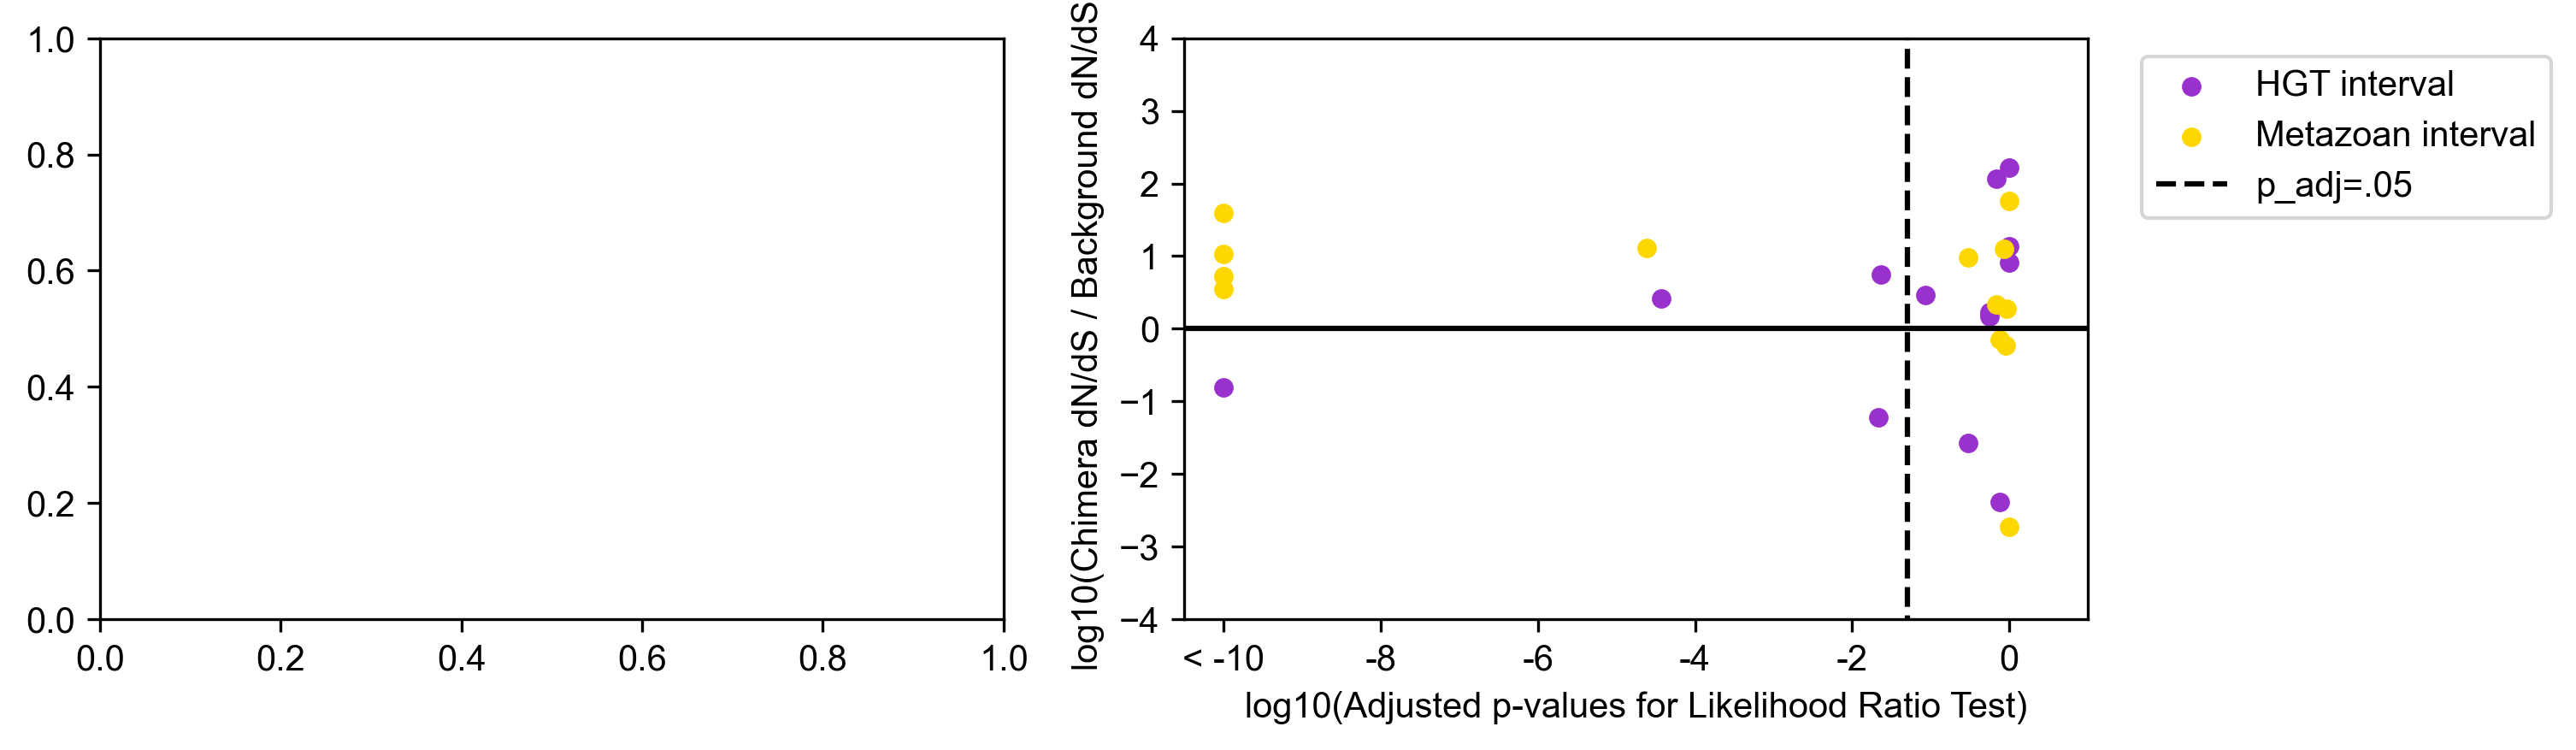

In [58]:
import matplotlib.pyplot as plt
import numpy as np
# Your data and scatter plot
fig,ax=plt.subplots(1,2,dpi=300,figsize=(10,3))
logfc= np.log10(list(combined_dnds[combined_dnds.annotation.str.contains("HGT")].dnds_bch /combined_dnds[combined_dnds.annotation.str.contains("HGT")].dnds_b))
padj=[max(x,-10) for x in np.log10(combined_dnds[combined_dnds.annotation.astype(str).str.contains("HGT")].corrected_p_values)]
plt.scatter(padj, logfc,color="darkorchid", s=20,label='HGT interval')

logfc= np.log10(list(combined_dnds[~combined_dnds.annotation.str.contains("HGT")].dnds_bch /combined_dnds[~combined_dnds.annotation.str.contains("HGT")].dnds_b))
padj=[max(x,-10) for x in np.log10(combined_dnds[~combined_dnds.annotation.str.contains("HGT")].corrected_p_values)]
ax[1].scatter(padj, logfc, s=20,color='gold',label='Metazoan interval')
# Labeling the axes
ax[1].set_ylabel("log10(Chimera dN/dS / Background dN/dS)")
ax[1].set_xlabel("log10(Adjusted p-values for Likelihood Ratio Test)")

ax[1].vlines(np.log10(.05),-5,5,linestyle='dashed',label="p_adj=.05",color='black')
ax[1].hlines(0,-11,20,color='black')

ax[1].set_xlim(-10.5,1)
ax[1].set_ylim(-4,4)
custom_ticks=[-10,-8,-6,-4,-2,0]
ax[1].set_xticks(ticks=custom_ticks)
tick_labels = [f"< {tick}" if tick == -10 else tick for tick in custom_ticks]
plt.gca().set_xticklabels(tick_labels)
ax[1].legend( bbox_to_anchor=(1.04, 1), loc="upper left")
plt.savefig("2branch_dnds_plot.svg",format="svg",bbox_inches="tight", transparent=True)

plt.show()
